### This notebook demonstrates the predictions of *JUST score* and *market returns* from each other

In [2]:
import numpy as np
import math 
import matplotlib.pyplot as plt
import xlrd
import pandas as pd
import scipy.cluster.hierarchy as hcluster
import scipy.spatial.distance
import copy
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
import random

Now load two data sets. "company_scores.xlsx" is for the *JUST scores*, and "returns1.xlsx" is for *market returns*. 

In [3]:
returns1_data = xlrd.open_workbook('/Users/xiaobooboo/Desktop/data_incubator/returns1.xlsx')
returns1=returns1_data.sheets()[0]

scores_data = xlrd.open_workbook('/Users/xiaobooboo/Desktop/data_incubator/company_scores.xlsx')
scores= scores_data.sheets()[0]
feature_names=scores.row_values(0)[3:]

nrows_scores= scores.nrows #1287
nperiods_returns1=returns1.ncols #898

returns1_ids=returns1.col_values(0)[2:]

Load the components of the JUST scores as feature vectors (1x47).

In [4]:
comp_vectors=[] #length=440 companies in total
comp_ids=[]
for i in range(1,nrows_scores):
    comp_vectors.append(scores.row_values(i)[3:])
    comp_ids.append(scores.row_values(i)[0])#---all companies-----
comp_vectors=np.asarray(comp_vectors)  

First, reduce the dimension of JUST scores by applying PCA (Principal Component Analysis) capturing 98% of variance

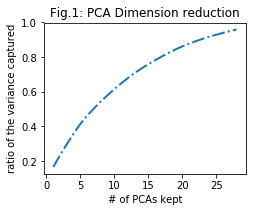

In [5]:
best_pca=0
ncs=1 #num of components kept
variance_bar=0.95

howgood=[]
ncs_kept=[]
while (best_pca<variance_bar) & (ncs<np.size(comp_vectors,1)):
    pca = PCA(n_components=ncs)
    pca.fit(comp_vectors)
    pca_score = pca.explained_variance_ratio_   #array([0.72408528,  0.27427885,  0.00163586])
    best_pca=sum(pca_score)
    howgood.append(best_pca)
    ncs_kept.append(ncs)
    ncs=ncs+1
    
ncs=ncs-1
V = pca.components_ 

plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(ncs_kept, howgood,linestyle='-.',linewidth=2)
plt.axis('tight')
plt.title('Fig.1: PCA Dimension reduction')
plt.xlabel('# of PCAs kept')
plt.ylabel('ratio of the variance captured')
plt.show()

From this figure we see that the first 28 PCAs are already able to capture 98% of the variance. This enables us to reduce the original feature vector of JUST score from 1x47 to 1x28

In [70]:
comp_reduced=np.ndarray(shape=(len(comp_ids),ncs),dtype=float)
for nn in range(len(comp_ids)):
    for cc in range(ncs):
        comp_reduced[nn,cc]=np.dot(comp_vectors[nn],V[cc])

comp_reduced.shape
comp_reduced=comp_reduced[1:][:] #(439, 28)


Now we want to cluster (hierarchical clustering) these companies in terms of their *JUST scores*. 

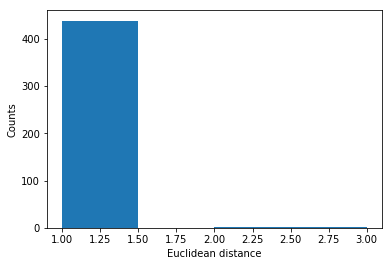

3

In [23]:
thresh=160 #this number, an arbitrary, results in a category of 3.  
clusters = hcluster.fclusterdata(comp_reduced, thresh, criterion="distance")
num_clusters=len(set(clusters)) 

plt.hist(clusters, bins=4)  # arguments are passed to np.histogram
plt.xlabel('Euclidean distance')
plt.ylabel('Counts')
plt.show()
num_clusters

From the histogram above, we see that only 3% of the companies distinguish themselves from the majority. More clustering techniques need to be further explored. For now, based on the current clustering, we demonstrate just the first compnay with one transition matrix. 

Below is merging the JUST score table and the market return table. As a result, we get 439 companies with 768 periods 

In [ ]:
d_returns1 = {'id': returns1_ids}
df_returns1 = pd.DataFrame(data=d_returns1)
for pp in range(1,nperiods_returns1):
    df_returns1[str(int(returns1.col_values(pp)[0]))]=returns1.col_values(pp)[2:]

df_returns1 = df_returns1.replace('', np.nan, regex=True) #a dataframe

d_compids = {'id': comp_ids}
df_compids = pd.DataFrame(data=d_compids) #(440, 1)

frames=[df_compids,df_returns1]
merged=df_returns1.join(df_compids.set_index('id'), on='id',how='inner') #(439, 898)
tmp=merged.dropna(axis=1, how='all') #(439, 768)
merged_id_returns1=tmp.dropna(axis=0, how='all') #(439, 768)



Before we start our statistical analysis, we first define 10 states for the the sequence of periods) of returns and normalize the time series by subtracting the mean.

In [ ]:
#---Step1: normalize the time series:439 companies, 768 periods------
returns1_normalized=copy.copy(merged_id_returns1)


for n in range(np.size(merged_id_returns1,0)):
    returns1_normalized.iloc[n][:]=merged_id_returns1.iloc[n][:]-np.nanmean(merged_id_returns1.iloc[n][:]) #this is a Series


bins=10 # num of states
returns1_max=np.nanmax(returns1_normalized.iloc[0][1:].values)
returns1_min=np.nanmin(returns1_normalized.iloc[0][1:].values)
returns1_std=np.nanstd(returns1_normalized.iloc[0][1:].values)
bin_width=(returns1_max-returns1_min)/bins

bin_marks=[] #should have bins+1 marks
for n in range(bins+1):
    bin_marks.append(returns1_min+n*bin_width)
    
bin_marks[0]=bin_marks[0]*1.1
bin_marks[-1]=bin_marks[-1]*1.1


We then discretize the time series (a sequence of periods) of market returns into the 10 states.

In [ ]:
%matplotlib inline

In [ ]:
#---Step2: discretize the data into different states------
returns1_discretized=copy.copy(returns1_normalized) #(439, 768)
for n in range(np.size(returns1_discretized,0)):
    for pp in range(1,np.size(returns1_discretized,1)):  #0 is id 
        state=0
        while state<11:             
            if (returns1_normalized.iloc[n][pp] <= bin_marks[state]) & (returns1_normalized.iloc[n][pp]>= bin_marks[state-1]):
                returns1_discretized.iloc[n][pp]=state
                #print(str(n)+';'+str(pp))
                break
            else:
                state=state+1
                
discrete_max=np.nanmax(returns1_discretized.iloc[0][1:].values)
discrete_min=np.nanmin(returns1_discretized.iloc[0][1:].values)     



Calculate the PDFs (Probability Distribution Function) of each company

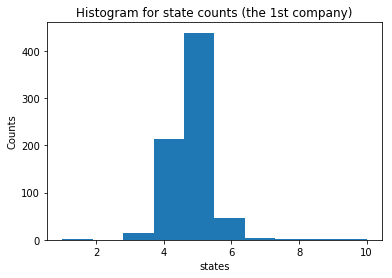

In [42]:
#---Step3: PDF: hist: 439 companies, 10 states------
hist=np.zeros(shape=(np.size(returns1_discretized,0),bins), dtype=int) #(439, 10)

for n in range(np.size(returns1_discretized,0)):
    A=returns1_discretized.iloc[n][1:].values
    hist[n]=np.histogram(A[~np.isnan(A)], bins=10)[0]
    
choose=0 #choose a company: the first one for now
A=returns1_discretized.iloc[choose][1:].values #the PDF of 1 company
plt.hist(A[~np.isnan(A)],bins=10)  # arguments are passed to np.histogram
plt.title("Histogram for state counts (the 1st company)")
plt.xlabel('states')
plt.ylabel('Counts')
plt.show()


Now we compute the transition matrix for the Markov process. 

In [41]:
#---Step4: transition matrix: one matrix each company------
choose=0 #choose a company
series=returns1_discretized.iloc[choose][1:] #767x1, Series, 0 is id

def transition_matrix(series):
#tot_jumps is len(series)-1
#1  time series(discretized); return a flattened transition matrix for training  
    bins=int(10)
    transitions=np.zeros(shape=(bins,bins), dtype=float)
    for m in range(len(series)-1):
        if (math.isnan(series[m])==False) & (math.isnan(series[m+1])==False):
            transitions[int(series[m]-1)][int(series[m+1]-1)]+=1
    #normalize:
    for rn in range(bins):
        #print(str(rn)+';'+str(np.nansum(transitions[rn])))
        if np.nansum(transitions[rn])!=0:
            transitions[rn]=np.divide(transitions[rn],np.nansum(transitions[rn]))
    return transitions

feature_transition= transition_matrix(series) #10x10, syn if which is 1

With the feature vector of transitions and the feature vector of PDF, we are ready to train our neural network. We first use 60% of the data (263 companies) for training.

In [45]:
train_perc=0.6
total_companies=439
hist_train=hist[0:int(total_companies*train_perc)] #(263, 10)

bins=10
transition_train=np.ndarray(shape=(int(total_companies*train_perc),bins*bins)) #(263, 100)
for nn in range(int(total_companies*train_perc)):
    series=returns1_discretized.iloc[nn][1:] #767x1, Series, 0 is id
    transition_train[nn][:]=np.ndarray.flatten(transition_matrix(series))
 
  
input_train=np.concatenate((hist_train,transition_train),axis=1) #(263, 110), labels

compJUST_train=comp_reduced[0:int(total_companies*train_perc)][:] #(263, 28), labels




model = MLPRegressor(
    hidden_layer_sizes=(10,),  activation='relu', solver='adam', alpha=0.001, batch_size='auto',
    learning_rate='constant', learning_rate_init=0.01, power_t=0.5, max_iter=1000, shuffle=True,
    random_state=9, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True,
    early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)


model.fit(input_train,compJUST_train)
model.get_params() #is a dictionary
#model.partial_fit(x, y)
#evaluated=nn.score(x, y) #1 number: float


{'activation': 'relu',
 'alpha': 0.001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (10,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.01,
 'max_iter': 1000,
 'momentum': 0.9,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 9,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

Now with the model trained, we can use it to predict the JUST score with the knowledge of statistics (PDF and transition matrix) of the market returns. We use the other 40% of the test data sets (176 companies).

In [52]:
test_perc=0.4
total_companies=439
hist_test=hist[int(total_companies*train_perc):] #(176, 10)

bins=int(10)
transition_test=np.ndarray(shape=(np.size(hist_test,0),bins*bins)) #(176, 100)
counter=0
for nn in range(np.size(hist_train,0),total_companies):
    #print(nn)
    series=returns1_discretized.iloc[nn][1:] #767x1, Series, 0 is id
    transition_test[counter]=np.matrix.flatten(transition_matrix(series))
    counter+=1



(176, 100)

In [77]:
input_test=np.concatenate((hist_test,transition_test),axis=1) #(176, 110)

compJUST_test=comp_reduced[int(total_companies*train_perc):][:] #(176, 28), labels

compJUST_predicted=model.predict(input_test) #(176, 28)

errors_test= np.sum(np.absolute(compJUST_predicted-compJUST_test),axis=1) #(176,)

Now we choose a feature that well divides the companies into clusters and plot prediction errors against it.

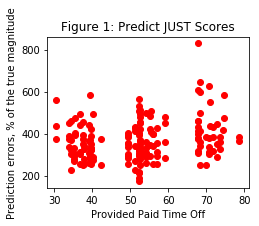

In [78]:
leader_test=comp_vectors[1:,12] #(439,) #12, 21
feature=feature_names[12]
leader_test=leader_test[int(total_companies*train_perc):] #(176,)


plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
#plt.scatter(wgt_Y1, errors_Y1,marker='^',c='blue')
plt.scatter(leader_test, errors_test,marker='o',c='red')
plt.title('Figure 1: Predict JUST Scores')
plt.axis('tight')
plt.xlabel('Provided Paid Time Off')
plt.ylabel('Prediction errors, % of the true magnitude')
plt.savefig('/Users/xiaobooboo/Desktop/data_incubator/predict_score.pdf',format='pdf')
plt.show()

One last note for the prediction of JUST scores, further exploration of about the coefficients trained in our Multi-layer neural network need to be done in order to squeeze the human-languaged insights out about the relation between JUST scores and Market returns. 

The other goal for this project is to predict the other way around: given a JUST score, can we predict the Market returns?

First, we need to construct the transition matrix for each company.

In [79]:
choose=9
series_build=returns1_discretized.iloc[choose][1:700] #(767,) #3, 8, 10, are interesting; 9 is good 
transitions=transition_matrix(series_build)

series_true=returns1_discretized.iloc[choose][700:] #(767,)

series_predict=copy.copy(series_true) #(767,)

Also we need to write a function which generates a random number according to a given PDF. The method adopted here is Inverse Transform Sampling.

In [80]:
def generator(cdf):
    seed=random.random()
    for n in range(len(cdf)-1):
        if (seed>cdf[n]) & (seed<cdf[n+1]):
            return n+1

Now given an initial conditional state, we can start predicing the time sequence of market returns.

In [95]:
previous=series_build.iloc[-1] #the initial condition

pdf=transitions[int(previous)-1]
cdf=np.cumsum(pdf)
#plt.plot(cdf)

cdf=np.insert(cdf, 0, 0)

for sss in range(len(series_predict)):
    series_predict.iloc[sss]=generator(cdf)
    previous=series_predict.iloc[sss]
    pdf=transitions[int(previous)-1]
    cdf=np.cumsum(pdf)
    cdf=np.insert(cdf, 0, 0)

Text(0,0.5,'discretized states')

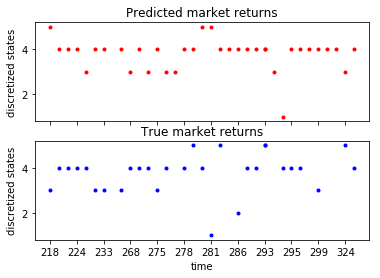

In [96]:

# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(2, sharex=True,  sharey='all')
axarr[0].plot(series_predict[0:35],'.',color='red')

axarr[0].set_title('Predicted market returns')
plt.xticks(np.arange(0, len(series_predict[0:35]), 3.0))
axarr[1].plot(series_true[0:35],'.',color='blue')
plt.xlabel('time')
axarr[1].set_title('True market returns')
axarr[0].set_ylabel('discretized states')
axarr[1].set_ylabel('discretized states')
